In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
from PIL import Image 

from matplotlib import pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [2]:
def load(image_file):
    # 이미지 읽어와서 그레이로 변환
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    gray = tf.image.rgb_to_grayscale(image)

    # 그레이 이미지와 원본이미지 텐서 변환
    input_image = tf.cast(gray, tf.float32)
    real_image = tf.cast(image, tf.float32)

    return input_image, real_image

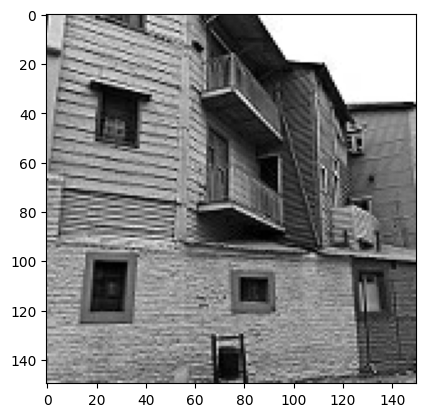

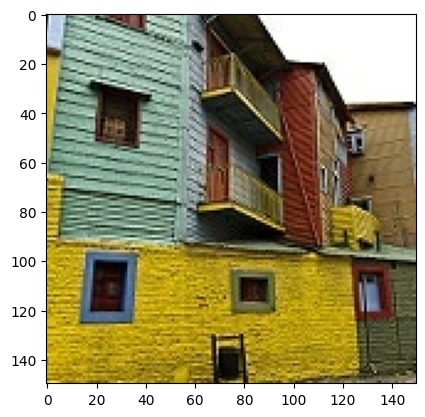

In [3]:
inp, re = load('./data/ori_train/4.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0, cmap='gray')
plt.figure()
plt.imshow(re / 255.0)

In [4]:


# 정규화 함수 [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

@tf.function()
def random_jitter(image):
    # 크롭을 위한 이미지 리사이즈 높이,너비 +20
    image = tf.image.resize(image, [IMG_HEIGHT+20, IMG_WIDTH+20], 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # 랜덤 크롭 진행 원래 크기로
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    # 랜덤 반전(미러링)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    
    return image

In [5]:
# 훈련 이미지 데이터세트 로더(전처리과정 통합)
def load_image_train(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    real_image = random_jitter(image)
    input_image = tf.image.rgb_to_grayscale(real_image)
    input_image = tf.cast(input_image, tf.float32)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# 테스트 이미지 데이터세트 로더(크롭 및 반전 x)
def load_image_test(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    real_image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], 
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.image.rgb_to_grayscale(real_image)
    input_image = tf.cast(input_image, tf.float32)

    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [6]:
# 버퍼 사이즈
BUFFER_SIZE = 32
# 배치 사이즈
BATCH_SIZE = 4
# 이미지 크기
IMG_WIDTH = 128
IMG_HEIGHT = 128

(150, 150, 1)


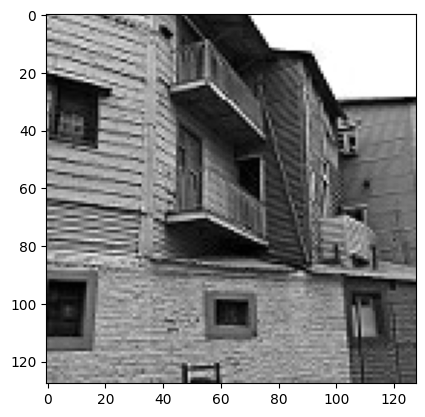

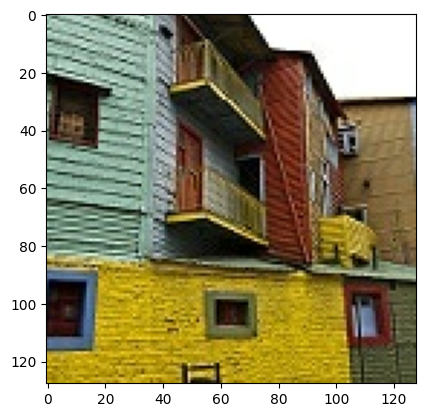

In [7]:
# 데이터세트 확인

input_image, real_image = load_image_train('./data/ori_train/4.jpg')
plt.figure()
plt.imshow(input_image * 0.5 + 0.5, cmap='gray')
plt.figure()
plt.imshow(real_image * 0.5 + 0.5)
print(inp.shape)

In [8]:
#학습 데이터 세트 구성

train_dataset = tf.data.Dataset.list_files('./data/ori_train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [9]:
#테스트 데이터 세트 구성

try:
    test_dataset = tf.data.Dataset.list_files('./data/ori_test/*.jpg')
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files('./data/ori_val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [33]:
for example_input, example_target in test_dataset.take(1):
    print(example_input.shape)
    print(example_target.shape)

(4, 128, 128, 1)
(4, 128, 128, 3)


In [11]:
# 컨볼루션 레이어 기반 다운 샘플
def downsample(filters, size, apply_batchnorm=True):

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [29]:
# 다운 샘플 확인
down_model = downsample(3, 4)
down_result = down_model(example_input, 0)
print (down_result.shape)

(4, 64, 64, 3)


In [13]:
#트랜스포즈 컨볼루션 기반 업샘플링
def upsample(filters, size, apply_dropout=False):

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [30]:
# 업샘플링 확인
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(4, 128, 128, 3)


In [15]:
# 다운샘플과 업샘플을 이용한 생성자 정의
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    
    # 다운 샘플 레이어 쌓기
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 32)
        downsample(64, 4),  # (batch_size, 32, 32, 64)
        downsample(128, 4),  # (batch_size, 16, 16, 128)
        downsample(256, 4),  # (batch_size, 8, 8, 256)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    
    # 업샘플 레이어 쌓기
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # skip -> (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # skip -> (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # skip -> (batch_size, 8, 8, 512)
        upsample(128, 4),  # skip -> (batch_size, 16, 16, 256)
        upsample(64, 4),  # skip -> (batch_size, 32, 32, 128)
        upsample(32, 4),  # skip -> (batch_size, 64, 64, 64)
    ]
    
    # 컬러 이미지로 변환하는 마지막 컨볼루션
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batch_size, 128, 128, 3)
                                                             # tanh으로 -1, 1 사이 값으로 변환 (0~1 정규화는 시그모이드사용)

    x = inputs

    # 다운 샘플층마다 결과값 리스트에 보관
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # 다운샘플 결과 역순 정렬
    skips = reversed(skips[:-1])

    # 스킵(concat) 를 통한 업샘플 과정
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

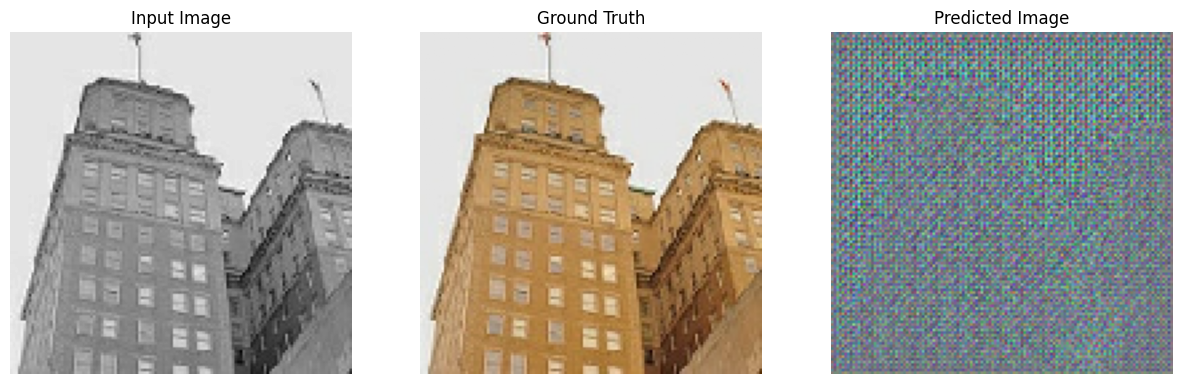

In [34]:
# 생성자 확인해보기

generator = Generator()

prediction = generator(example_input, training=True)
plt.figure(figsize=(15, 15))

display_list = [example_input[0], example_target[0], prediction[0]]
title = ['Input Image', 'Ground Truth', 'Predicted Image']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    if i == 0:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
plt.show()


In [37]:
# Cnn 바이너리 분류 팔별자 정의
def Discriminator():

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 128, 128, 4)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 32, 32, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 16, 16, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 18, 18, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                use_bias=False)(zero_pad1)  # (batch_size, 15, 15, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 17, 17, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,)(zero_pad2)  # (batch_size, 14, 14, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [40]:
discriminator = Discriminator()
disc_out = discriminator([example_input, example_target], training=False)
disc_out[0]

<tf.Tensor: shape=(14, 14, 1), dtype=float32, numpy=
array([[[0.02723046],
        [0.04420842],
        [0.07768764],
        [0.06393946],
        [0.08725411],
        [0.06221671],
        [0.08701109],
        [0.08009774],
        [0.10374239],
        [0.08969995],
        [0.09946055],
        [0.09685864],
        [0.10272383],
        [0.04566212]],

       [[0.100596  ],
        [0.07534932],
        [0.10291226],
        [0.11398297],
        [0.13636093],
        [0.13139476],
        [0.1198808 ],
        [0.14769532],
        [0.15603155],
        [0.14704905],
        [0.13689046],
        [0.13915372],
        [0.14747237],
        [0.11651693]],

       [[0.08504991],
        [0.09242725],
        [0.08654014],
        [0.11503166],
        [0.10677979],
        [0.09305616],
        [0.06313919],
        [0.10188993],
        [0.09495804],
        [0.0962572 ],
        [0.15632632],
        [0.17435515],
        [0.16042016],
        [0.13985309]],

       [[0.081047

In [31]:
# 생성자 손실 정의

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    
    # 1 & 생성이미지 판별값 BCE (판별값이 1에 가까울수록 손실 적음)
    binary_gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # 실제 이미지 $ 생성이미지 MAE
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # 생성이미지가 1에 가깝고 실제이미지와 픽셀값이 비슷할때 손실 최소
    total_gen_loss = binary_gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, binary_gan_loss, l1_loss

In [20]:
#판별자 손실 정의

def discriminator_loss(disc_real_output, disc_generated_output):
    
    # 1 & 실제이미지 판별값 BCE (판별값이 1에 가까울수록 손실 적음)
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # 0 & 생성이미지 판별값 BCE (판별값이 0에 가까울수록 손실 적음)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # 생성이미지는 0으로 실제이미지는 1로 판별할경우 손실 최소
    total_disc_loss = real_loss + generated_loss 

    return total_disc_loss

In [21]:
# 최적화 정의 생성자 판별자 따로(생성자 손실, 판별자 손실)

generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.9)

# 체크포인트 생성
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
def generate_save(model, test_input, step):
    prediction = model(test_input, training=False)
    img = prediction[0] * 0.5 + 0.5
    img = tf.keras.utils.array_to_img(img * 255)
    img.save('./data/gimage/{}.jpg'.format(step))

In [23]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #이미지 생성
        gen_output = generator(input_image, training=True)

        # 실제이미지와의 판별
        disc_real_output = discriminator([input_image, target], training=True)
        # 생성이미지와의 판별
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        # 생성자 손실
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        # 판별자 손실
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # 생성자 손실 그래디언트
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    # 판별자 손실 그래디언트
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    # 생성자 역전파
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    # 판별자 역전파
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
        
    return gen_total_loss, disc_loss

In [26]:

def fit(train_ds, test_ds, steps):
    # 이미지 생성 변화를 보기위한 테스트 이미지 
    test_sample = iter(test_ds.take(100))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        step = np.asarray(step)
        
        gen_total_loss, disc_loss = train_step(input_image, target, step)
        
        if step % 500 == 0:
            print('G_loss : {}, D_loss : {}'.format(gen_total_loss, disc_loss))
            if step != 0:
                print(f'Time taken for 300 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            # 500에포크 마다 테스트 생성이미지 저장
            example_input, example_target = next(test_sample)
            generate_save(generator, example_input, step)
            print(f"Step: {step}")
        
     
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # 1000에포크 마다 체크포인트 저장
        if (step + 1) % 1000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [27]:
fit(train_dataset, test_dataset, steps=40000)

G_loss : 13.49915885925293, D_loss : 1.105625033378601
Step: 0
..................................................G_loss : 13.862882614135742, D_loss : 0.9548271894454956
Time taken for 300 steps: 22.91 sec

Step: 500
..................................................G_loss : 15.716413497924805, D_loss : 0.2550583481788635
Time taken for 300 steps: 24.25 sec

Step: 1000
..................................................G_loss : 15.17770767211914, D_loss : 0.6149861216545105
Time taken for 300 steps: 22.36 sec

Step: 1500
..................................................G_loss : 14.127912521362305, D_loss : 0.30939969420433044
Time taken for 300 steps: 23.53 sec

Step: 2000
..................................................G_loss : 16.619829177856445, D_loss : 0.03287208825349808
Time taken for 300 steps: 22.31 sec

Step: 2500
..................................................G_loss : 21.7868709564209, D_loss : 0.10627725720405579
Time taken for 300 steps: 24.75 sec

Step: 3000
........

KeyboardInterrupt: 